In [3]:
import pandas as pd
import os

# Update with your CSV path
csv_path = os.path.expanduser('~/Downloads/top10k_logos.csv')

print("Loading CSV to check columns...")
df = pd.read_csv(csv_path, nrows=5)  # Only load first 5 rows

print("\n" + "="*60)
print("COLUMN NAMES IN YOUR CSV:")
print("="*60)
for i, col in enumerate(df.columns, 1):
    print(f"{i}. {col}")

print("\n" + "="*60)
print("FIRST FEW ROWS:")
print("="*60)
print(df.head())

print("\n" + "="*60)
print("COLUMNS CONTAINING 'CATEGORY':")
print("="*60)
category_cols = [col for col in df.columns if 'category' in col.lower()]
if category_cols:
    for col in category_cols:
        print(f"  - {col}")
        print(f"    Sample value: {df[col].iloc[0]}")
else:
    print("  No columns with 'category' found")

print("\n" + "="*60)
print("COLUMNS CONTAINING 'GROUP':")
print("="*60)
group_cols = [col for col in df.columns if 'group' in col.lower()]
if group_cols:
    for col in group_cols:
        print(f"  - {col}")
        print(f"    Sample value: {df[col].iloc[0]}")
else:
    print("  No columns with 'group' found")

Loading CSV to check columns...

COLUMN NAMES IN YOUR CSV:
1. uuid
2. name
3. type
4. permalink
5. cb_url
6. rank
7. created_at
8. updated_at
9. legal_name
10. roles
11. domain
12. homepage_url
13. region
14. city
15. address
16. postal_code
17. status
18. short_description
19. num_funding_rounds
20. total_funding_usd
21. total_funding
22. total_funding_currency_code
23. founded_on
24. last_funding_on
25. closed_on
26. employee_count
27. email
28. phone
29. facebook_url
30. linkedin_url
31. twitter_url
32. state_code
33. logo_url
34. country_code
35. category_groups_list
36. category_list
37. new_logo_url

FIRST FEW ROWS:
                                   uuid      name          type  \
0  1a410398-3a72-5882-99b8-6318cf594850  SoftBank  organization   
1  2cc3a5de-2303-aa00-cd1a-50bd96420392    Klarna  organization   
2  84c5275e-2a2f-e43a-1ff1-1a5f7c79975f    Apollo  organization   
3  0c4f065f-524f-fb08-8c17-305b43755705    Nubank  organization   
4  00daca16-8311-454b-84e0-24a40d16

In [1]:
import os
import pandas as pd
from tqdm import tqdm
from collections import Counter

# Configuration
logo_dir = os.path.expanduser('~/Downloads/logo_images')
input_csv = os.path.expanduser('~/Downloads/top10k_logos.csv')
output_csv = os.path.expanduser('~/Downloads/clean_training_data.csv')
target_column = 'category_groups_list'  # or 'category_groups_list'

# Optional filtering
max_categories = 50  # Set to None to keep all categories
max_samples = 1000   # Set to None to keep all samples

print("="*60)
print("CREATING CLEAN CSV FOR TRAINING")
print("="*60)

# Step 1: Load logo files
print("\nStep 1: Reading logo files...")
logo_files = {}
for filename in os.listdir(logo_dir):
    if filename.lower().endswith(('.png', '.jpg', '.jpeg')):
        parts = filename.split('_', 1)
        if len(parts) >= 2:
            name = os.path.splitext(parts[1])[0]
            logo_files[name.lower()] = filename

print(f"Found {len(logo_files)} logo files")

# Step 2: Load CSV with only necessary columns
print("\nStep 2: Loading CSV...")
df = pd.read_csv(input_csv)

# Keep only essential columns
essential_columns = ['uuid', 'name', target_column]
df = df[essential_columns].copy()

print(f"Loaded {len(df)} rows")
print(f"Kept columns: {', '.join(essential_columns)}")

# Step 3: Remove rows without categories
print("\nStep 3: Filtering rows...")
original_count = len(df)
df = df[df[target_column].notna()].copy()
print(f"Removed {original_count - len(df)} rows without categories")

# Step 4: Match logos
print("\nStep 4: Matching logos to companies...")
matched_files = []
unmatched_count = 0
unmatched_examples = []

for idx, row in tqdm(df.iterrows(), total=len(df), desc="Matching"):
    csv_name = str(row['name']).strip()
    csv_name_lower = csv_name.lower()
    
    if csv_name_lower in logo_files:
        matched_files.append(logo_files[csv_name_lower])
    else:
        # Try without spaces/hyphens/dots
        csv_name_clean = csv_name_lower.replace(' ', '').replace('-', '').replace('.', '')
        found = False
        for logo_name, logo_file in logo_files.items():
            logo_name_clean = logo_name.replace(' ', '').replace('-', '').replace('.', '')
            if csv_name_clean == logo_name_clean:
                matched_files.append(logo_file)
                found = True
                break
        if not found:
            matched_files.append(None)
            unmatched_count += 1
            if len(unmatched_examples) < 10:
                unmatched_examples.append(csv_name)

df['logo_filename'] = matched_files

print(f"\n✅ Matched: {len(df) - unmatched_count} companies with logos")
print(f"❌ Unmatched: {unmatched_count} companies without logos")

if unmatched_count > 0:
    print(f"\nExample unmatched companies:")
    for name in unmatched_examples[:5]:
        print(f"  - {name}")

# Remove rows without matching logos
before_removal = len(df)
df = df[df['logo_filename'].notna()].copy()
print(f"\nRemoved {before_removal - len(df)} rows without logos")
print(f"Remaining rows: {len(df)}")

if len(df) == 0:
    print("\n" + "="*60)
    print("ERROR: No companies matched with logos!")
    print("="*60)
    print("Debugging info:")
    print(f"Logo files found: {len(logo_files)}")
    print(f"CSV rows: {before_removal}")
    print("\nSample logo file names:")
    for name, file in list(logo_files.items())[:5]:
        print(f"  '{name}' -> {file}")
    print("\nThis might be a case sensitivity or naming issue.")
    print("="*60)
    exit()

# Step 5: Filter to top N categories (optional)
if max_categories:
    print(f"\nStep 5: Filtering to top {max_categories} categories...")
    
    all_categories = []
    for cats in df[target_column]:
        if pd.notna(cats):
            all_categories.extend([cat.strip() for cat in str(cats).split(',')])
    
    category_counts = Counter(all_categories)
    top_categories = set([cat for cat, _ in category_counts.most_common(max_categories)])
    
    print(f"\nTop {min(10, max_categories)} categories:")
    for cat, count in category_counts.most_common(min(10, max_categories)):
        print(f"  {cat}: {count} samples")
    
    # Keep only rows with at least one top category
    def has_top_category(cats):
        if pd.isna(cats):
            return False
        cat_list = [cat.strip() for cat in str(cats).split(',')]
        return any(cat in top_categories for cat in cat_list)
    
    before_filter = len(df)
    df = df[df[target_column].apply(has_top_category)].copy()
    print(f"\nKept {len(df)} samples with top categories (removed {before_filter - len(df)})")

# Step 6: Limit to max_samples (optional)
if max_samples and len(df) > max_samples:
    print(f"\nStep 6: Randomly sampling {max_samples} samples...")
    df = df.sample(n=max_samples, random_state=42).reset_index(drop=True)
    print(f"Kept {len(df)} samples")

# Step 7: Save clean CSV
print(f"\nStep 7: Saving clean CSV...")
df = df.reset_index(drop=True)
df.to_csv(output_csv, index=False)

# Calculate file sizes
original_size = os.path.getsize(input_csv) / 1024 / 1024
new_size = os.path.getsize(output_csv) / 1024 / 1024

# Final summary
print("\n" + "="*60)
print("SUMMARY")
print("="*60)
print(f"Original CSV: {original_count} rows, {original_size:.2f} MB")
print(f"Clean CSV: {len(df)} rows, {new_size:.2f} MB")
print(f"Size reduction: {(1 - new_size/original_size) * 100:.1f}%")
print(f"\nColumns in clean CSV: {', '.join(df.columns)}")

# Category statistics
all_cats = []
for cats in df[target_column]:
    if pd.notna(cats):
        all_cats.extend([cat.strip() for cat in str(cats).split(',')])

unique_categories = len(set(all_cats))
print(f"\nUnique categories: {unique_categories}")
print(f"Average categories per company: {len(all_cats) / len(df):.2f}")
print(f"\nOutput saved to: {output_csv}")
print("\n✅ Ready for training! Use this CSV in your training script.")

CREATING CLEAN CSV FOR TRAINING

Step 1: Reading logo files...
Found 9896 logo files

Step 2: Loading CSV...
Loaded 10000 rows
Kept columns: uuid, name, category_groups_list

Step 3: Filtering rows...
Removed 0 rows without categories

Step 4: Matching logos to companies...


Matching: 100%|███████████████████████████████████████████████████████████████| 10000/10000 [00:00<00:00, 32706.93it/s]


✅ Matched: 9988 companies with logos
❌ Unmatched: 12 companies without logos

Example unmatched companies:
  - Ever/Body
  - The/Studio
  - ATTN:
  - Care/of
  - Oak HC/FT

Removed 12 rows without logos
Remaining rows: 9988

Step 5: Filtering to top 50 categories...

Top 10 categories:
  Software: 5088 samples
  Financial Services: 2376 samples
  Information Technology: 2307 samples
  Science and Engineering: 2054 samples
  Internet Services: 2013 samples
  Data and Analytics: 1903 samples
  Health Care: 1720 samples
  Hardware: 1463 samples
  Other: 1377 samples
  Commerce and Shopping: 1371 samples

Kept 9988 samples with top categories (removed 0)

Step 6: Randomly sampling 1000 samples...
Kept 1000 samples

Step 7: Saving clean CSV...

SUMMARY
Original CSV: 10000 rows, 8.97 MB
Clean CSV: 1000 rows, 0.13 MB
Size reduction: 98.6%

Columns in clean CSV: uuid, name, category_groups_list, logo_filename

Unique categories: 47
Average categories per company: 3.81

Output saved to: C:\Use

In [2]:
import os
import pandas as pd
import numpy as np
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader
from torchvision import models, transforms
from PIL import Image
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import MultiLabelBinarizer
import matplotlib.pyplot as plt
from tqdm import tqdm

# Configuration
CONFIG = {
    'csv_path': os.path.expanduser('~/Downloads/clean_training_data.csv'),
    'logo_dir': os.path.expanduser('~/Downloads/logo_images'),
    'target_column': 'category_list',  # or 'category_groups_list'
    'img_size': 224,
    'batch_size': 16,
    'num_epochs': 30,
    'learning_rate': 0.001,
    'device': 'cuda' if torch.cuda.is_available() else 'cpu',
    'num_workers': 0,
    'test_size': 0.2,
    'val_size': 0.1,
}

class LogoDataset(Dataset):
    """Custom Dataset for loading company logos"""
    
    def __init__(self, dataframe, logo_dir, mlb, transform=None):
        self.df = dataframe.reset_index(drop=True)
        self.logo_dir = logo_dir
        self.mlb = mlb
        self.transform = transform
        
    def __len__(self):
        return len(self.df)
    
    def __getitem__(self, idx):
        row = self.df.iloc[idx]
        
        # Get logo filename from the dataframe (pre-matched)
        if 'logo_filename' in self.df.columns and pd.notna(row['logo_filename']):
            logo_path = os.path.join(self.logo_dir, row['logo_filename'])
        else:
            # Fallback: try to construct filename from uuid and name
            uuid = row['uuid']
            name = str(row['name']).replace(' ', '_').replace('/', '_')
            
            logo_path = None
            for ext in ['.png', '.jpg', '.jpeg', '.PNG', '.JPG']:
                potential_path = os.path.join(self.logo_dir, f"{uuid}_{name}{ext}")
                if os.path.exists(potential_path):
                    logo_path = potential_path
                    break
        
        if logo_path is None or not os.path.exists(logo_path):
            # Return a blank image if logo not found
            image = Image.new('RGB', (CONFIG['img_size'], CONFIG['img_size']), color='white')
        else:
            image = Image.open(logo_path).convert('RGB')
        
        if self.transform:
            image = self.transform(image)
        
        # Get multi-label target
        categories = row['categories']
        if pd.isna(categories) or categories == '':
            categories = []
        else:
            categories = [cat.strip() for cat in str(categories).split(',')]
        
        label = self.mlb.transform([categories])[0]
        
        return image, torch.FloatTensor(label)

def prepare_data(csv_path, target_column):
    """Load and prepare the dataset"""
    # Read full CSV first
    df = pd.read_csv(csv_path)
    
    # Check if target column exists
    if target_column not in df.columns:
        raise ValueError(f"Column '{target_column}' not found! Available: {df.columns.tolist()}")
    
    # Keep only necessary columns
    required_cols = ['uuid', 'name', target_column]
    df = df[required_cols].copy()
    
    # Keep only rows with valid categories
    df = df[df[target_column].notna()].copy()
    df['categories'] = df[target_column]
    
    # Filter out rows where logo file doesn't exist
    valid_rows = []
    logo_dir = CONFIG['logo_dir']
    
    print("Checking for existing logo files...")
    for idx, row in tqdm(df.iterrows(), total=len(df), desc="Validating logos"):
        uuid = row['uuid']
        name = row['name'].replace(' ', '_').replace('/', '_')
        
        # Check if logo exists
        logo_exists = False
        for ext in ['.png', '.jpg', '.jpeg', '.PNG', '.JPG', '.JPEG']:
            potential_path = os.path.join(logo_dir, f"{uuid}_{name}{ext}")
            if os.path.exists(potential_path):
                logo_exists = True
                break
        
        if logo_exists:
            valid_rows.append(idx)
    
    df = df.loc[valid_rows].reset_index(drop=True)
    print(f"Found {len(df)} samples with existing logos")
    
    # Optional: Limit total samples for faster training
    if CONFIG.get('max_samples') and len(df) > CONFIG['max_samples']:
        df = df.sample(n=CONFIG['max_samples'], random_state=42).reset_index(drop=True)
        print(f"Randomly sampled {CONFIG['max_samples']} samples for faster training")
    
    # Extract all unique categories
    all_categories = []
    for cats in df['categories']:
        if pd.notna(cats):
            all_categories.extend([cat.strip() for cat in str(cats).split(',')])
    
    unique_categories = sorted(set(all_categories))
    print(f"Found {len(unique_categories)} unique categories")
    
    # Optional: Filter to only top N most common categories
    if CONFIG.get('max_categories'):
        from collections import Counter
        category_counts = Counter(all_categories)
        top_categories = [cat for cat, _ in category_counts.most_common(CONFIG['max_categories'])]
        
        # Keep only rows with at least one top category
        def has_top_category(cats):
            if pd.isna(cats):
                return False
            cat_list = [cat.strip() for cat in str(cats).split(',')]
            return any(cat in top_categories for cat in cat_list)
        
        df = df[df['categories'].apply(has_top_category)].reset_index(drop=True)
        unique_categories = top_categories
        print(f"Filtered to top {len(unique_categories)} categories, {len(df)} samples remaining")
    
    # Create MultiLabelBinarizer
    mlb = MultiLabelBinarizer()
    mlb.fit([unique_categories])
    
    # Split data
    train_val_df, test_df = train_test_split(
        df, test_size=CONFIG['test_size'], random_state=42
    )
    train_df, val_df = train_test_split(
        train_val_df, test_size=CONFIG['val_size'], random_state=42
    )
    
    print(f"Train: {len(train_df)}, Val: {len(val_df)}, Test: {len(test_df)}")
    
    return train_df, val_df, test_df, mlb

def get_transforms():
    """Define image transformations"""
    train_transform = transforms.Compose([
        transforms.Resize((CONFIG['img_size'], CONFIG['img_size'])),
        transforms.RandomHorizontalFlip(),
        transforms.RandomRotation(10),
        transforms.ColorJitter(brightness=0.2, contrast=0.2),
        transforms.ToTensor(),
        transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
    ])
    
    val_transform = transforms.Compose([
        transforms.Resize((CONFIG['img_size'], CONFIG['img_size'])),
        transforms.ToTensor(),
        transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
    ])
    
    return train_transform, val_transform

class ResNetClassifier(nn.Module):
    """ResNet model for multi-label classification"""
    
    def __init__(self, num_classes, pretrained=True):
        super(ResNetClassifier, self).__init__()
        self.resnet = models.resnet50(pretrained=pretrained)
        
        # Replace the final fully connected layer
        num_features = self.resnet.fc.in_features
        self.resnet.fc = nn.Sequential(
            nn.Dropout(0.5),
            nn.Linear(num_features, num_classes)
        )
    
    def forward(self, x):
        return self.resnet(x)

def train_epoch(model, dataloader, criterion, optimizer, device):
    """Train for one epoch"""
    model.train()
    running_loss = 0.0
    
    progress_bar = tqdm(dataloader, desc='Training')
    for batch_idx, (images, labels) in enumerate(progress_bar):
        images, labels = images.to(device), labels.to(device)
        
        optimizer.zero_grad()
        outputs = model(images)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()
        
        running_loss += loss.item() * images.size(0)
        
        # Update progress bar with current loss
        avg_loss = running_loss / ((batch_idx + 1) * images.size(0))
        progress_bar.set_postfix({'loss': f'{avg_loss:.4f}'})
    
    epoch_loss = running_loss / len(dataloader.dataset)
    return epoch_loss

def validate(model, dataloader, criterion, device):
    """Validate the model"""
    model.eval()
    running_loss = 0.0
    all_preds = []
    all_labels = []
    
    with torch.no_grad():
        for images, labels in tqdm(dataloader, desc='Validation'):
            images, labels = images.to(device), labels.to(device)
            
            outputs = model(images)
            loss = criterion(outputs, labels)
            
            running_loss += loss.item() * images.size(0)
            
            preds = torch.sigmoid(outputs) > 0.5
            all_preds.append(preds.cpu())
            all_labels.append(labels.cpu())
    
    epoch_loss = running_loss / len(dataloader.dataset)
    
    # Calculate accuracy
    all_preds = torch.cat(all_preds)
    all_labels = torch.cat(all_labels)
    accuracy = (all_preds == all_labels).float().mean().item()
    
    return epoch_loss, accuracy

def main():
    """Main training pipeline"""
    print(f"Using device: {CONFIG['device']}")
    
    # Prepare data
    train_df, val_df, test_df, mlb = prepare_data(
        CONFIG['csv_path'], CONFIG['target_column']
    )
    num_classes = len(mlb.classes_)
    print(f"Number of classes: {num_classes}")
    
    # Get transforms
    train_transform, val_transform = get_transforms()
    
    # Create datasets
    train_dataset = LogoDataset(train_df, CONFIG['logo_dir'], mlb, train_transform)
    val_dataset = LogoDataset(val_df, CONFIG['logo_dir'], mlb, val_transform)
    test_dataset = LogoDataset(test_df, CONFIG['logo_dir'], mlb, val_transform)
    
    # Create dataloaders
    train_loader = DataLoader(
        train_dataset, batch_size=CONFIG['batch_size'], 
        shuffle=True, num_workers=CONFIG['num_workers']
    )
    val_loader = DataLoader(
        val_dataset, batch_size=CONFIG['batch_size'], 
        shuffle=False, num_workers=CONFIG['num_workers']
    )
    test_loader = DataLoader(
        test_dataset, batch_size=CONFIG['batch_size'], 
        shuffle=False, num_workers=CONFIG['num_workers']
    )
    
    # Initialize model
    model = ResNetClassifier(num_classes, pretrained=True)
    model = model.to(CONFIG['device'])
    
    # Loss and optimizer
    criterion = nn.BCEWithLogitsLoss()
    optimizer = optim.Adam(model.parameters(), lr=CONFIG['learning_rate'])
    scheduler = optim.lr_scheduler.ReduceLROnPlateau(
        optimizer, mode='min', factor=0.5, patience=3
    )
    
    # Warn if using CPU
    if CONFIG['device'] == 'cpu':
        print("\n" + "="*60)
        print("WARNING: Training on CPU - this will be VERY slow!")
        print("Consider using Google Colab (free GPU) or reducing batch size")
        print("="*60 + "\n")
    
    # Training loop
    best_val_loss = float('inf')
    train_losses = []
    val_losses = []
    val_accuracies = []
    
    for epoch in range(CONFIG['num_epochs']):
        print(f"\nEpoch {epoch+1}/{CONFIG['num_epochs']}")
        
        train_loss = train_epoch(model, train_loader, criterion, optimizer, CONFIG['device'])
        val_loss, val_acc = validate(model, val_loader, criterion, CONFIG['device'])
        
        train_losses.append(train_loss)
        val_losses.append(val_loss)
        val_accuracies.append(val_acc)
        
        print(f"Train Loss: {train_loss:.4f}")
        print(f"Val Loss: {val_loss:.4f}, Val Accuracy: {val_acc:.4f}")
        
        scheduler.step(val_loss)
        
        # Save best model
        if val_loss < best_val_loss:
            best_val_loss = val_loss
            torch.save({
                'epoch': epoch,
                'model_state_dict': model.state_dict(),
                'optimizer_state_dict': optimizer.state_dict(),
                'val_loss': val_loss,
                'mlb': mlb,
                'config': CONFIG
            }, 'best_model.pth')
            print("Saved best model!")
    
    # Test evaluation
    print("\nEvaluating on test set...")
    test_loss, test_acc = validate(model, test_loader, criterion, CONFIG['device'])
    print(f"Test Loss: {test_loss:.4f}, Test Accuracy: {test_acc:.4f}")
    
    # Plot training curves
    plt.figure(figsize=(12, 4))
    
    plt.subplot(1, 2, 1)
    plt.plot(train_losses, label='Train Loss')
    plt.plot(val_losses, label='Val Loss')
    plt.xlabel('Epoch')
    plt.ylabel('Loss')
    plt.legend()
    plt.title('Training and Validation Loss')
    
    plt.subplot(1, 2, 2)
    plt.plot(val_accuracies, label='Val Accuracy')
    plt.xlabel('Epoch')
    plt.ylabel('Accuracy')
    plt.legend()
    plt.title('Validation Accuracy')
    
    plt.tight_layout()
    plt.savefig('training_curves.png')
    print("Training curves saved to 'training_curves.png'")

if __name__ == '__main__':
    main()

Using device: cpu
Checking for existing logo files...


Validating logos: 100%|██████████████████████████████████████████████████████████| 1000/1000 [00:00<00:00, 8827.85it/s]

Found 0 samples with existing logos
Found 0 unique categories


ValueError: With n_samples=0, test_size=0.2 and train_size=None, the resulting train set will be empty. Adjust any of the aforementioned parameters.

In [4]:
import os
import pandas as pd
import numpy as np
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader
from torchvision import models, transforms
from PIL import Image
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import MultiLabelBinarizer
import matplotlib.pyplot as plt
from tqdm import tqdm

# Configuration
CONFIG = {
    'csv_path': os.path.expanduser('~/Downloads/clean_training_data.csv'),
    'logo_dir': os.path.expanduser('~/Downloads/logo_images'),
    'target_column': 'category_list',  # or 'category_groups_list'
    'img_size': 224,
    'batch_size': 16,
    'num_epochs': 30,
    'learning_rate': 0.001,
    'device': 'cuda' if torch.cuda.is_available() else 'cpu',
    'num_workers': 0,
    'test_size': 0.2,
    'val_size': 0.1,
}

class LogoDataset(Dataset):
    """Custom Dataset for loading company logos"""
    
    def __init__(self, dataframe, logo_dir, mlb, transform=None):
        self.df = dataframe.reset_index(drop=True)
        self.logo_dir = logo_dir
        self.mlb = mlb
        self.transform = transform
        
    def __len__(self):
        return len(self.df)
    
    def __getitem__(self, idx):
        row = self.df.iloc[idx]
        
        # Get logo filename from the dataframe (pre-matched)
        if 'logo_filename' in self.df.columns and pd.notna(row['logo_filename']):
            logo_path = os.path.join(self.logo_dir, row['logo_filename'])
        else:
            # Fallback: try to construct filename from uuid and name
            uuid = row['uuid']
            name = str(row['name']).replace(' ', '_').replace('/', '_')
            
            logo_path = None
            for ext in ['.png', '.jpg', '.jpeg', '.PNG', '.JPG']:
                potential_path = os.path.join(self.logo_dir, f"{uuid}_{name}{ext}")
                if os.path.exists(potential_path):
                    logo_path = potential_path
                    break
        
        if logo_path is None or not os.path.exists(logo_path):
            # Return a blank image if logo not found
            image = Image.new('RGB', (CONFIG['img_size'], CONFIG['img_size']), color='white')
        else:
            image = Image.open(logo_path).convert('RGB')
        
        if self.transform:
            image = self.transform(image)
        
        # Get multi-label target
        categories = row['categories']
        if pd.isna(categories) or categories == '':
            categories = []
        else:
            categories = [cat.strip() for cat in str(categories).split(',')]
        
        label = self.mlb.transform([categories])[0]
        
        return image, torch.FloatTensor(label)

def prepare_data(csv_path, target_column):
    """Load and prepare the dataset"""
    # Read full CSV first
    df = pd.read_csv(csv_path)
    
    # Check if target column exists
    if target_column not in df.columns:
        raise ValueError(f"Column '{target_column}' not found! Available: {df.columns.tolist()}")
    
    # Keep only necessary columns
    required_cols = ['uuid', 'name', target_column]
    df = df[required_cols].copy()
    
    # Keep only rows with valid categories
    df = df[df[target_column].notna()].copy()
    df['categories'] = df[target_column]
    
    # Filter out rows where logo file doesn't exist
    valid_rows = []
    logo_dir = CONFIG['logo_dir']
    
    print("Checking for existing logo files...")
    for idx, row in tqdm(df.iterrows(), total=len(df), desc="Validating logos"):
        uuid = row['uuid']
        name = row['name'].replace(' ', '_').replace('/', '_')
        
        # Check if logo exists
        logo_exists = False
        for ext in ['.png', '.jpg', '.jpeg', '.PNG', '.JPG', '.JPEG']:
            potential_path = os.path.join(logo_dir, f"{uuid}_{name}{ext}")
            if os.path.exists(potential_path):
                logo_exists = True
                break
        
        if logo_exists:
            valid_rows.append(idx)
    
    df = df.loc[valid_rows].reset_index(drop=True)
    print(f"Found {len(df)} samples with existing logos")
    
    # Optional: Limit total samples for faster training
    if CONFIG.get('max_samples') and len(df) > CONFIG['max_samples']:
        df = df.sample(n=CONFIG['max_samples'], random_state=42).reset_index(drop=True)
        print(f"Randomly sampled {CONFIG['max_samples']} samples for faster training")
    
    # Extract all unique categories
    all_categories = []
    for cats in df['categories']:
        if pd.notna(cats):
            all_categories.extend([cat.strip() for cat in str(cats).split(',')])
    
    unique_categories = sorted(set(all_categories))
    print(f"Found {len(unique_categories)} unique categories")
    
    # Optional: Filter to only top N most common categories
    if CONFIG.get('max_categories'):
        from collections import Counter
        category_counts = Counter(all_categories)
        top_categories = [cat for cat, _ in category_counts.most_common(CONFIG['max_categories'])]
        
        # Keep only rows with at least one top category
        def has_top_category(cats):
            if pd.isna(cats):
                return False
            cat_list = [cat.strip() for cat in str(cats).split(',')]
            return any(cat in top_categories for cat in cat_list)
        
        df = df[df['categories'].apply(has_top_category)].reset_index(drop=True)
        unique_categories = top_categories
        print(f"Filtered to top {len(unique_categories)} categories, {len(df)} samples remaining")
    
    # Create MultiLabelBinarizer
    mlb = MultiLabelBinarizer()
    mlb.fit([unique_categories])
    
    # Split data
    train_val_df, test_df = train_test_split(
        df, test_size=CONFIG['test_size'], random_state=42
    )
    train_df, val_df = train_test_split(
        train_val_df, test_size=CONFIG['val_size'], random_state=42
    )
    
    print(f"Train: {len(train_df)}, Val: {len(val_df)}, Test: {len(test_df)}")
    
    return train_df, val_df, test_df, mlb

def get_transforms():
    """Define image transformations"""
    train_transform = transforms.Compose([
        transforms.Resize((CONFIG['img_size'], CONFIG['img_size'])),
        transforms.RandomHorizontalFlip(),
        transforms.RandomRotation(10),
        transforms.ColorJitter(brightness=0.2, contrast=0.2),
        transforms.ToTensor(),
        transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
    ])
    
    val_transform = transforms.Compose([
        transforms.Resize((CONFIG['img_size'], CONFIG['img_size'])),
        transforms.ToTensor(),
        transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
    ])
    
    return train_transform, val_transform

class ResNetClassifier(nn.Module):
    """ResNet model for multi-label classification"""
    
    def __init__(self, num_classes, pretrained=True):
        super(ResNetClassifier, self).__init__()
        self.resnet = models.resnet50(pretrained=pretrained)
        
        # Replace the final fully connected layer
        num_features = self.resnet.fc.in_features
        self.resnet.fc = nn.Sequential(
            nn.Dropout(0.5),
            nn.Linear(num_features, num_classes)
        )
    
    def forward(self, x):
        return self.resnet(x)

def train_epoch(model, dataloader, criterion, optimizer, device):
    """Train for one epoch"""
    model.train()
    running_loss = 0.0
    
    progress_bar = tqdm(dataloader, desc='Training')
    for batch_idx, (images, labels) in enumerate(progress_bar):
        images, labels = images.to(device), labels.to(device)
        
        optimizer.zero_grad()
        outputs = model(images)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()
        
        running_loss += loss.item() * images.size(0)
        
        # Update progress bar with current loss
        avg_loss = running_loss / ((batch_idx + 1) * images.size(0))
        progress_bar.set_postfix({'loss': f'{avg_loss:.4f}'})
    
    epoch_loss = running_loss / len(dataloader.dataset)
    return epoch_loss

def validate(model, dataloader, criterion, device):
    """Validate the model"""
    model.eval()
    running_loss = 0.0
    all_preds = []
    all_labels = []
    
    with torch.no_grad():
        for images, labels in tqdm(dataloader, desc='Validation'):
            images, labels = images.to(device), labels.to(device)
            
            outputs = model(images)
            loss = criterion(outputs, labels)
            
            running_loss += loss.item() * images.size(0)
            
            preds = torch.sigmoid(outputs) > 0.5
            all_preds.append(preds.cpu())
            all_labels.append(labels.cpu())
    
    epoch_loss = running_loss / len(dataloader.dataset)
    
    # Calculate accuracy
    all_preds = torch.cat(all_preds)
    all_labels = torch.cat(all_labels)
    accuracy = (all_preds == all_labels).float().mean().item()
    
    return epoch_loss, accuracy

def main():
    """Main training pipeline"""
    print(f"Using device: {CONFIG['device']}")
    
    # Prepare data
    train_df, val_df, test_df, mlb = prepare_data(
        CONFIG['csv_path'], CONFIG['target_column']
    )
    num_classes = len(mlb.classes_)
    print(f"Number of classes: {num_classes}")
    
    # Get transforms
    train_transform, val_transform = get_transforms()
    
    # Create datasets
    train_dataset = LogoDataset(train_df, CONFIG['logo_dir'], mlb, train_transform)
    val_dataset = LogoDataset(val_df, CONFIG['logo_dir'], mlb, val_transform)
    test_dataset = LogoDataset(test_df, CONFIG['logo_dir'], mlb, val_transform)
    
    # Create dataloaders
    train_loader = DataLoader(
        train_dataset, batch_size=CONFIG['batch_size'], 
        shuffle=True, num_workers=CONFIG['num_workers']
    )
    val_loader = DataLoader(
        val_dataset, batch_size=CONFIG['batch_size'], 
        shuffle=False, num_workers=CONFIG['num_workers']
    )
    test_loader = DataLoader(
        test_dataset, batch_size=CONFIG['batch_size'], 
        shuffle=False, num_workers=CONFIG['num_workers']
    )
    
    # Initialize model
    model = ResNetClassifier(num_classes, pretrained=True)
    model = model.to(CONFIG['device'])
    
    # Loss and optimizer
    criterion = nn.BCEWithLogitsLoss()
    optimizer = optim.Adam(model.parameters(), lr=CONFIG['learning_rate'])
    scheduler = optim.lr_scheduler.ReduceLROnPlateau(
        optimizer, mode='min', factor=0.5, patience=3
    )
    
    # Warn if using CPU
    if CONFIG['device'] == 'cpu':
        print("\n" + "="*60)
        print("WARNING: Training on CPU - this will be VERY slow!")
        print("Consider using Google Colab (free GPU) or reducing batch size")
        print("="*60 + "\n")
    
    # Training loop
    best_val_loss = float('inf')
    train_losses = []
    val_losses = []
    val_accuracies = []
    
    for epoch in range(CONFIG['num_epochs']):
        print(f"\nEpoch {epoch+1}/{CONFIG['num_epochs']}")
        
        train_loss = train_epoch(model, train_loader, criterion, optimizer, CONFIG['device'])
        val_loss, val_acc = validate(model, val_loader, criterion, CONFIG['device'])
        
        train_losses.append(train_loss)
        val_losses.append(val_loss)
        val_accuracies.append(val_acc)
        
        print(f"Train Loss: {train_loss:.4f}")
        print(f"Val Loss: {val_loss:.4f}, Val Accuracy: {val_acc:.4f}")
        
        scheduler.step(val_loss)
        
        # Save best model
        if val_loss < best_val_loss:
            best_val_loss = val_loss
            torch.save({
                'epoch': epoch,
                'model_state_dict': model.state_dict(),
                'optimizer_state_dict': optimizer.state_dict(),
                'val_loss': val_loss,
                'mlb': mlb,
                'config': CONFIG
            }, 'best_model.pth')
            print("Saved best model!")
    
    # Test evaluation
    print("\nEvaluating on test set...")
    test_loss, test_acc = validate(model, test_loader, criterion, CONFIG['device'])
    print(f"Test Loss: {test_loss:.4f}, Test Accuracy: {test_acc:.4f}")
    
    # Plot training curves
    plt.figure(figsize=(12, 4))
    
    plt.subplot(1, 2, 1)
    plt.plot(train_losses, label='Train Loss')
    plt.plot(val_losses, label='Val Loss')
    plt.xlabel('Epoch')
    plt.ylabel('Loss')
    plt.legend()
    plt.title('Training and Validation Loss')
    
    plt.subplot(1, 2, 2)
    plt.plot(val_accuracies, label='Val Accuracy')
    plt.xlabel('Epoch')
    plt.ylabel('Accuracy')
    plt.legend()
    plt.title('Validation Accuracy')
    
    plt.tight_layout()
    plt.savefig('training_curves.png')
    print("Training curves saved to 'training_curves.png'")

if __name__ == '__main__':
    main()

Using device: cpu
Checking for existing logo files...


Validating logos: 100%|██████████████████████████████████████████████████████████| 1000/1000 [00:00<00:00, 9404.67it/s]

Found 0 samples with existing logos
Found 0 unique categories


ValueError: With n_samples=0, test_size=0.2 and train_size=None, the resulting train set will be empty. Adjust any of the aforementioned parameters.

C:\Users\jchen\AppData\Local\Programs\Python\Python313\Lib\site-packages\torchvision\models\_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
C:\Users\jchen\AppData\Local\Programs\Python\Python313\Lib\site-packages\torchvision\models\_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet18_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet18_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


LOGO CLASSIFICATION TRAINING
Device: cpu

⚠️  WARNING: Training on CPU will be slow!
Consider using Google Colab for free GPU access

LOADING DATA
Loading data from: C:\Users\jchen/Downloads/clean_training_data.csv
✅ Loaded 1000 rows
Columns: ['uuid', 'name', 'category_list', 'logo_filename']
After filtering: 1000 rows (removed 0)
Unique categories: 458
Number of classes: 458

Splitting data...
Train: 720
Val: 80
Test: 200

CREATING DATASETS
✅ Datasets created

INITIALIZING MODEL
✅ ResNet18 model initialized

STARTING TRAINING

Epoch 1/20


Training:  48%|████████████████████████████▏                              | 11/23 [00:05<00:05,  2.33it/s, loss=0.2706]

Validation: 100%|████████████████████████████████████████████████████████████████████████| 3/3 [00:00<00:00,  7.64it/s]


Train Loss: 0.1579
Val Loss: 0.0514, Val Accuracy: 0.9906
💾 Saved best model!

Epoch 2/20


Training:  83%|████████████████████████████████████████████████▋          | 19/23 [00:07<00:01,  2.40it/s, loss=0.0493]

Training:  87%|███████████████████████████████████████████████████▎       | 20/23 [00:08<00:01,  2.43it/s, loss=0.0492]

Validation: 100%|████████████████████████████████████████████████████████████████████████| 3/3 [00:00<00:00,  7.29it/s]


Train Loss: 0.0488
Val Loss: 0.0469, Val Accuracy: 0.9906
💾 Saved best model!

Epoch 3/20


Training:  35%|████████████████████▊                                       | 8/23 [00:03<00:06,  2.36it/s, loss=0.0476]

Training:  61%|███████████████████████████████████▉                       | 14/23 [00:05<00:03,  2.40it/s, loss=0.0463]

Validation: 100%|████████████████████████████████████████████████████████████████████████| 3/3 [00:00<00:00,  7.77it/s]


Train Loss: 0.0458
Val Loss: 0.0444, Val Accuracy: 0.9906
💾 Saved best model!

Epoch 4/20


Training:  39%|███████████████████████▍                                    | 9/23 [00:03<00:05,  2.40it/s, loss=0.0463]

Training:  52%|██████████████████████████████▊                            | 12/23 [00:05<00:04,  2.44it/s, loss=0.0458]

Validation: 100%|████████████████████████████████████████████████████████████████████████| 3/3 [00:00<00:00,  7.65it/s]


Train Loss: 0.0455
Val Loss: 0.0442, Val Accuracy: 0.9906
💾 Saved best model!

Epoch 5/20


Training:   4%|██▌                                                         | 1/23 [00:00<00:08,  2.49it/s, loss=0.0407]

Training:  87%|███████████████████████████████████████████████████▎       | 20/23 [00:08<00:01,  2.43it/s, loss=0.0451]

Validation: 100%|████████████████████████████████████████████████████████████████████████| 3/3 [00:00<00:00,  8.12it/s]


Train Loss: 0.0452
Val Loss: 0.0448, Val Accuracy: 0.9906

Epoch 6/20


Training:  17%|██████████▍                                                 | 4/23 [00:01<00:07,  2.40it/s, loss=0.0456]

Training:  96%|████████████████████████████████████████████████████████▍  | 22/23 [00:09<00:00,  2.41it/s, loss=0.0450]

Validation: 100%|████████████████████████████████████████████████████████████████████████| 3/3 [00:00<00:00,  7.11it/s]


Train Loss: 0.0450
Val Loss: 0.0447, Val Accuracy: 0.9906

Epoch 7/20


Training:  13%|███████▊                                                    | 3/23 [00:01<00:08,  2.35it/s, loss=0.0458]

Training:  43%|█████████████████████████▋                                 | 10/23 [00:04<00:05,  2.34it/s, loss=0.0440]

Validation: 100%|████████████████████████████████████████████████████████████████████████| 3/3 [00:00<00:00,  7.43it/s]


Train Loss: 0.0443
Val Loss: 0.0452, Val Accuracy: 0.9904

Epoch 8/20


Training:   9%|█████▏                                                      | 2/23 [00:00<00:08,  2.46it/s, loss=0.0447]

Training:  17%|██████████▍                                                 | 4/23 [00:01<00:07,  2.42it/s, loss=0.0433]

Validation: 100%|████████████████████████████████████████████████████████████████████████| 3/3 [00:00<00:00,  8.03it/s]


Train Loss: 0.0442
Val Loss: 0.0456, Val Accuracy: 0.9906

Epoch 9/20


Training:  74%|███████████████████████████████████████████▌               | 17/23 [00:07<00:02,  2.33it/s, loss=0.0425]

Training:  83%|████████████████████████████████████████████████▋          | 19/23 [00:07<00:01,  2.25it/s, loss=0.0426]

Validation: 100%|████████████████████████████████████████████████████████████████████████| 3/3 [00:00<00:00,  7.23it/s]


Train Loss: 0.0431
Val Loss: 0.0456, Val Accuracy: 0.9904

Epoch 10/20


Training:  70%|█████████████████████████████████████████                  | 16/23 [00:06<00:02,  2.48it/s, loss=0.0417]

Training:  87%|███████████████████████████████████████████████████▎       | 20/23 [00:08<00:01,  2.38it/s, loss=0.0420]

Validation: 100%|████████████████████████████████████████████████████████████████████████| 3/3 [00:00<00:00,  7.74it/s]


Train Loss: 0.0420
Val Loss: 0.0455, Val Accuracy: 0.9904

Epoch 11/20


Training:  13%|███████▊                                                    | 3/23 [00:01<00:08,  2.40it/s, loss=0.0444]

Training:  17%|██████████▍                                                 | 4/23 [00:01<00:07,  2.46it/s, loss=0.0436]

Validation: 100%|████████████████████████████████████████████████████████████████████████| 3/3 [00:00<00:00,  8.11it/s]


Train Loss: 0.0417
Val Loss: 0.0475, Val Accuracy: 0.9901

Epoch 12/20


Training:  22%|█████████████                                               | 5/23 [00:02<00:07,  2.44it/s, loss=0.0413]

Training:  52%|██████████████████████████████▊                            | 12/23 [00:04<00:04,  2.46it/s, loss=0.0399]

Validation: 100%|████████████████████████████████████████████████████████████████████████| 3/3 [00:00<00:00,  7.99it/s]


Train Loss: 0.0407
Val Loss: 0.0472, Val Accuracy: 0.9905

Epoch 13/20


Training:  30%|██████████████████▎                                         | 7/23 [00:02<00:06,  2.38it/s, loss=0.0375]

Training:  96%|████████████████████████████████████████████████████████▍  | 22/23 [00:09<00:00,  2.43it/s, loss=0.0394]

Validation: 100%|████████████████████████████████████████████████████████████████████████| 3/3 [00:00<00:00,  7.09it/s]


Train Loss: 0.0393
Val Loss: 0.0474, Val Accuracy: 0.9904

Epoch 14/20


Training:   4%|██▌                                                         | 1/23 [00:00<00:08,  2.56it/s, loss=0.0376]

Training:  35%|████████████████████▊                                       | 8/23 [00:03<00:06,  2.49it/s, loss=0.0375]

Validation: 100%|████████████████████████████████████████████████████████████████████████| 3/3 [00:00<00:00,  8.01it/s]


Train Loss: 0.0382
Val Loss: 0.0471, Val Accuracy: 0.9903

Epoch 15/20


Training:  43%|█████████████████████████▋                                 | 10/23 [00:04<00:05,  2.38it/s, loss=0.0361]

Training:  91%|█████████████████████████████████████████████████████▊     | 21/23 [00:08<00:00,  2.44it/s, loss=0.0370]

Validation: 100%|████████████████████████████████████████████████████████████████████████| 3/3 [00:00<00:00,  8.09it/s]


Train Loss: 0.0370
Val Loss: 0.0482, Val Accuracy: 0.9901

Epoch 16/20


Training:  43%|█████████████████████████▋                                 | 10/23 [00:04<00:05,  2.29it/s, loss=0.0361]

Training:  48%|████████████████████████████▏                              | 11/23 [00:04<00:05,  2.28it/s, loss=0.0361]

Validation: 100%|████████████████████████████████████████████████████████████████████████| 3/3 [00:00<00:00,  8.08it/s]


Train Loss: 0.0361
Val Loss: 0.0483, Val Accuracy: 0.9903

Epoch 17/20


Training:  35%|████████████████████▊                                       | 8/23 [00:03<00:06,  2.39it/s, loss=0.0336]

Training:  87%|███████████████████████████████████████████████████▎       | 20/23 [00:08<00:01,  2.47it/s, loss=0.0340]

Validation: 100%|████████████████████████████████████████████████████████████████████████| 3/3 [00:00<00:00,  8.17it/s]


Train Loss: 0.0340
Val Loss: 0.0481, Val Accuracy: 0.9903

Epoch 18/20


Training:   4%|██▌                                                         | 1/23 [00:00<00:08,  2.53it/s, loss=0.0356]

Training:  52%|██████████████████████████████▊                            | 12/23 [00:04<00:04,  2.45it/s, loss=0.0337]

Validation: 100%|████████████████████████████████████████████████████████████████████████| 3/3 [00:00<00:00,  7.78it/s]


Train Loss: 0.0331
Val Loss: 0.0489, Val Accuracy: 0.9898

Epoch 19/20


Training:  30%|██████████████████▎                                         | 7/23 [00:02<00:06,  2.38it/s, loss=0.0329]

Training:  78%|██████████████████████████████████████████████▏            | 18/23 [00:07<00:02,  2.31it/s, loss=0.0322]

Validation: 100%|████████████████████████████████████████████████████████████████████████| 3/3 [00:00<00:00,  7.94it/s]


Train Loss: 0.0320
Val Loss: 0.0488, Val Accuracy: 0.9903

Epoch 20/20


Training:  26%|███████████████▋                                            | 6/23 [00:02<00:07,  2.38it/s, loss=0.0302]

Training:  30%|██████████████████▎                                         | 7/23 [00:02<00:06,  2.40it/s, loss=0.0308]

Validation: 100%|████████████████████████████████████████████████████████████████████████| 3/3 [00:00<00:00,  7.84it/s]


Train Loss: 0.0313
Val Loss: 0.0496, Val Accuracy: 0.9900

FINAL EVALUATION


Validation:  14%|██████████▎                                                             | 1/7 [00:00<00:02,  2.64it/s]

Validation: 100%|████████████████████████████████████████████████████████████████████████| 7/7 [00:02<00:00,  2.91it/s]


Test Loss: 0.0504
Test Accuracy: 0.9896

📊 Training curves saved to 'training_curves.png'

✅ Training complete!


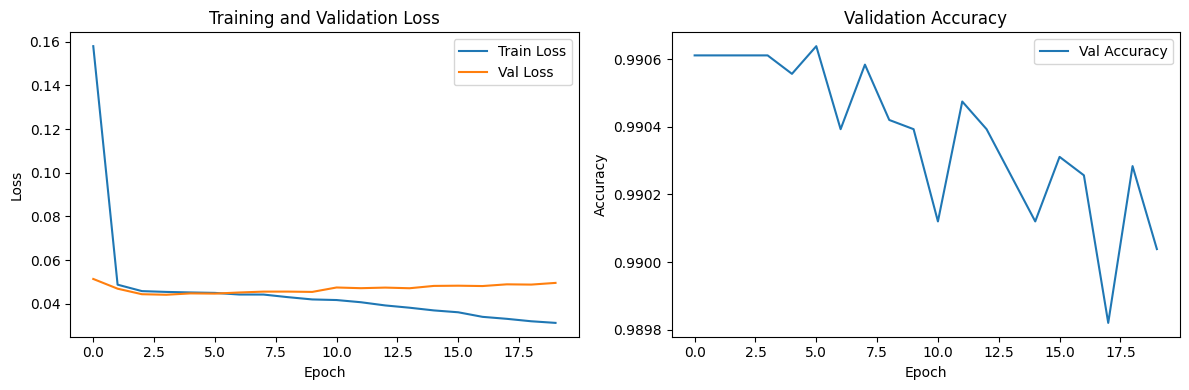

In [1]:
import os
import pandas as pd
import numpy as np
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader
from torchvision import models, transforms
from PIL import Image
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import MultiLabelBinarizer
import matplotlib.pyplot as plt
from tqdm import tqdm

# Configuration
CONFIG = {
    'csv_path': os.path.expanduser('~/Downloads/clean_training_data.csv'),
    'logo_dir': os.path.expanduser('~/Downloads/logo_images'),
    'target_column': 'category_list',
    'img_size': 128,  # Reduced from 224 (4x faster!)
    'batch_size': 32,  # Increased (2x faster)
    'num_epochs': 20,  # Reduced from 30
    'learning_rate': 0.001,
    'device': 'cuda' if torch.cuda.is_available() else 'cpu',
    'num_workers': 0,
    'test_size': 0.2,
    'val_size': 0.1,
    'use_resnet18': True,  # Use smaller model (4x faster than ResNet50)
}

class LogoDataset(Dataset):
    """Custom Dataset for loading company logos"""
    
    def __init__(self, dataframe, logo_dir, mlb, transform=None):
        self.df = dataframe.reset_index(drop=True)
        self.logo_dir = logo_dir
        self.mlb = mlb
        self.transform = transform
        
    def __len__(self):
        return len(self.df)
    
    def __getitem__(self, idx):
        row = self.df.iloc[idx]
        
        # Get logo filename directly from the CSV
        logo_filename = row['logo_filename']
        logo_path = os.path.join(self.logo_dir, logo_filename)
        
        # Load image with error handling
        try:
            if os.path.exists(logo_path):
                image = Image.open(logo_path).convert('RGB')
            else:
                print(f"Warning: Logo not found: {logo_path}")
                image = Image.new('RGB', (CONFIG['img_size'], CONFIG['img_size']), color='white')
        except Exception as e:
            print(f"Warning: Could not load image {logo_path}: {e}")
            # Create a blank white image as fallback
            image = Image.new('RGB', (CONFIG['img_size'], CONFIG['img_size']), color='white')
        
        if self.transform:
            image = self.transform(image)
        
        # Get multi-label target
        categories = row['categories']
        if pd.isna(categories) or categories == '':
            categories = []
        else:
            categories = [cat.strip() for cat in str(categories).split(',')]
        
        label = self.mlb.transform([categories])[0]
        
        return image, torch.FloatTensor(label)

def load_and_prepare_data():
    """Load the clean CSV and prepare for training"""
    print(f"Loading data from: {CONFIG['csv_path']}")
    
    # Load CSV
    df = pd.read_csv(CONFIG['csv_path'])
    print(f"✅ Loaded {len(df)} rows")
    print(f"Columns: {df.columns.tolist()}")
    
    # Verify required columns exist
    required = ['name', CONFIG['target_column'], 'logo_filename']
    missing = [col for col in required if col not in df.columns]
    if missing:
        raise ValueError(f"Missing required columns: {missing}")
    
    # Filter out any rows without categories or logos
    original_len = len(df)
    df = df[df[CONFIG['target_column']].notna()].copy()
    df = df[df['logo_filename'].notna()].copy()
    
    print(f"After filtering: {len(df)} rows (removed {original_len - len(df)})")
    
    if len(df) == 0:
        raise ValueError("No valid data after filtering!")
    
    # Add categories column for easy access
    df['categories'] = df[CONFIG['target_column']]
    
    # Extract all unique categories
    all_categories = []
    for cats in df['categories']:
        if pd.notna(cats):
            all_categories.extend([cat.strip() for cat in str(cats).split(',')])
    
    unique_categories = sorted(set(all_categories))
    print(f"Unique categories: {len(unique_categories)}")
    
    # Create MultiLabelBinarizer
    mlb = MultiLabelBinarizer()
    mlb.fit([unique_categories])
    
    return df, mlb

def split_data(df):
    """Split data into train/val/test"""
    print(f"\nSplitting data...")
    train_val_df, test_df = train_test_split(
        df, test_size=CONFIG['test_size'], random_state=42
    )
    train_df, val_df = train_test_split(
        train_val_df, test_size=CONFIG['val_size'], random_state=42
    )
    
    print(f"Train: {len(train_df)}")
    print(f"Val: {len(val_df)}")
    print(f"Test: {len(test_df)}")
    
    return train_df, val_df, test_df

def get_transforms():
    """Define image transformations"""
    train_transform = transforms.Compose([
        transforms.Resize((CONFIG['img_size'], CONFIG['img_size'])),
        transforms.RandomHorizontalFlip(),
        transforms.RandomRotation(10),
        transforms.ColorJitter(brightness=0.2, contrast=0.2),
        transforms.ToTensor(),
        transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
    ])
    
    val_transform = transforms.Compose([
        transforms.Resize((CONFIG['img_size'], CONFIG['img_size'])),
        transforms.ToTensor(),
        transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
    ])
    
    return train_transform, val_transform

class ResNetClassifier(nn.Module):
    """ResNet model for multi-label classification"""
    
    def __init__(self, num_classes, pretrained=True, use_resnet18=False):
        super(ResNetClassifier, self).__init__()
        
        if use_resnet18:
            self.resnet = models.resnet18(pretrained=pretrained)
        else:
            self.resnet = models.resnet50(pretrained=pretrained)
        
        # Replace the final fully connected layer
        num_features = self.resnet.fc.in_features
        self.resnet.fc = nn.Sequential(
            nn.Dropout(0.5),
            nn.Linear(num_features, num_classes)
        )
    
    def forward(self, x):
        return self.resnet(x)

def train_epoch(model, dataloader, criterion, optimizer, device):
    """Train for one epoch"""
    model.train()
    running_loss = 0.0
    
    progress_bar = tqdm(dataloader, desc='Training')
    for batch_idx, (images, labels) in enumerate(progress_bar):
        images, labels = images.to(device), labels.to(device)
        
        optimizer.zero_grad()
        outputs = model(images)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()
        
        running_loss += loss.item() * images.size(0)
        
        # Update progress bar with current loss
        avg_loss = running_loss / ((batch_idx + 1) * images.size(0))
        progress_bar.set_postfix({'loss': f'{avg_loss:.4f}'})
    
    epoch_loss = running_loss / len(dataloader.dataset)
    return epoch_loss

def validate(model, dataloader, criterion, device):
    """Validate the model"""
    model.eval()
    running_loss = 0.0
    all_preds = []
    all_labels = []
    
    with torch.no_grad():
        for images, labels in tqdm(dataloader, desc='Validation'):
            images, labels = images.to(device), labels.to(device)
            
            outputs = model(images)
            loss = criterion(outputs, labels)
            
            running_loss += loss.item() * images.size(0)
            
            preds = torch.sigmoid(outputs) > 0.5
            all_preds.append(preds.cpu())
            all_labels.append(labels.cpu())
    
    epoch_loss = running_loss / len(dataloader.dataset)
    
    # Calculate accuracy
    all_preds = torch.cat(all_preds)
    all_labels = torch.cat(all_labels)
    accuracy = (all_preds == all_labels).float().mean().item()
    
    return epoch_loss, accuracy

def main():
    """Main training pipeline"""
    print("="*60)
    print("LOGO CLASSIFICATION TRAINING")
    print("="*60)
    print(f"Device: {CONFIG['device']}")
    
    if CONFIG['device'] == 'cpu':
        print("\n⚠️  WARNING: Training on CPU will be slow!")
        print("Consider using Google Colab for free GPU access")
    
    # Load data
    print("\n" + "="*60)
    print("LOADING DATA")
    print("="*60)
    df, mlb = load_and_prepare_data()
    num_classes = len(mlb.classes_)
    print(f"Number of classes: {num_classes}")
    
    # Split data
    train_df, val_df, test_df = split_data(df)
    
    # Get transforms
    train_transform, val_transform = get_transforms()
    
    # Create datasets
    print("\n" + "="*60)
    print("CREATING DATASETS")
    print("="*60)
    train_dataset = LogoDataset(train_df, CONFIG['logo_dir'], mlb, train_transform)
    val_dataset = LogoDataset(val_df, CONFIG['logo_dir'], mlb, val_transform)
    test_dataset = LogoDataset(test_df, CONFIG['logo_dir'], mlb, val_transform)
    
    # Create dataloaders
    train_loader = DataLoader(
        train_dataset, batch_size=CONFIG['batch_size'], 
        shuffle=True, num_workers=CONFIG['num_workers']
    )
    val_loader = DataLoader(
        val_dataset, batch_size=CONFIG['batch_size'], 
        shuffle=False, num_workers=CONFIG['num_workers']
    )
    test_loader = DataLoader(
        test_dataset, batch_size=CONFIG['batch_size'], 
        shuffle=False, num_workers=CONFIG['num_workers']
    )
    
    print(f"✅ Datasets created")
    
    # Initialize model
    print("\n" + "="*60)
    print("INITIALIZING MODEL")
    print("="*60)
    model_name = "ResNet18" if CONFIG['use_resnet18'] else "ResNet50"
    model = ResNetClassifier(num_classes, pretrained=True, use_resnet18=CONFIG['use_resnet18'])
    model = model.to(CONFIG['device'])
    print(f"✅ {model_name} model initialized")
    
    # Loss and optimizer
    criterion = nn.BCEWithLogitsLoss()
    optimizer = optim.Adam(model.parameters(), lr=CONFIG['learning_rate'])
    scheduler = optim.lr_scheduler.ReduceLROnPlateau(
        optimizer, mode='min', factor=0.5, patience=3
    )
    
    # Training loop
    print("\n" + "="*60)
    print("STARTING TRAINING")
    print("="*60)
    best_val_loss = float('inf')
    train_losses = []
    val_losses = []
    val_accuracies = []
    
    for epoch in range(CONFIG['num_epochs']):
        print(f"\nEpoch {epoch+1}/{CONFIG['num_epochs']}")
        
        train_loss = train_epoch(model, train_loader, criterion, optimizer, CONFIG['device'])
        val_loss, val_acc = validate(model, val_loader, criterion, CONFIG['device'])
        
        train_losses.append(train_loss)
        val_losses.append(val_loss)
        val_accuracies.append(val_acc)
        
        print(f"Train Loss: {train_loss:.4f}")
        print(f"Val Loss: {val_loss:.4f}, Val Accuracy: {val_acc:.4f}")
        
        scheduler.step(val_loss)
        
        # Save best model
        if val_loss < best_val_loss:
            best_val_loss = val_loss
            torch.save({
                'epoch': epoch,
                'model_state_dict': model.state_dict(),
                'optimizer_state_dict': optimizer.state_dict(),
                'val_loss': val_loss,
                'mlb': mlb,
                'config': CONFIG
            }, 'best_model.pth')
            print("💾 Saved best model!")
    
    # Test evaluation
    print("\n" + "="*60)
    print("FINAL EVALUATION")
    print("="*60)
    test_loss, test_acc = validate(model, test_loader, criterion, CONFIG['device'])
    print(f"Test Loss: {test_loss:.4f}")
    print(f"Test Accuracy: {test_acc:.4f}")
    
    # Plot training curves
    plt.figure(figsize=(12, 4))
    
    plt.subplot(1, 2, 1)
    plt.plot(train_losses, label='Train Loss')
    plt.plot(val_losses, label='Val Loss')
    plt.xlabel('Epoch')
    plt.ylabel('Loss')
    plt.legend()
    plt.title('Training and Validation Loss')
    
    plt.subplot(1, 2, 2)
    plt.plot(val_accuracies, label='Val Accuracy')
    plt.xlabel('Epoch')
    plt.ylabel('Accuracy')
    plt.legend()
    plt.title('Validation Accuracy')
    
    plt.tight_layout()
    plt.savefig('training_curves.png')
    print("\n📊 Training curves saved to 'training_curves.png'")
    print("\n✅ Training complete!")

if __name__ == '__main__':
    main()

In [1]:
import torch
print(torch.cuda.is_available())
print(torch.cuda.get_device_name(0))

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(device)

import sys
print(sys.executable)


True
NVIDIA GeForce RTX 3060
cuda
C:\Users\jchen\AppData\Local\Programs\Python\Python313\python.exe
